### Install packages

Note that _hazard_ requires many more packages than _physrisk_, reflecting its role in generating indicators. There are a couple of ways to install the necessary packages.
#### 1 Install using pipenv via command line (recommended)

e.g. from Elyra JupyterLab, go File -> New -> Terminal to create a new terminal, then:

    cd hazard
    pipenv install

#### 2 Install using pip in notebook

First it's necessary to create requirements.txt from Pipfile and then install via pip:

    pipenv requirements > requirements.txt
    pip install -r requirements.txt

https://pipenv.pypa.io/en/latest/advanced/  
Might be useful for those who like to install in the notebook itself, but note that this appears to be a recent feature of pipenv (might not be installed in older images).

### Insert bucket name and credentials as environment variables
Need file credentials.env at top level (i.e. same level as LICENSE), containing:

OSC_S3_BUCKET=... \
OSC_S3_ACCESS_KEY=... \
OSC_S3_SECRET_KEY=...

In [4]:
import os, sys  # noqa: E402

sys.path.append("../src")
import hazard.utilities.zarr_utilities as zarr_utilities  # noqa: E402

os.environ["CREDENTIAL_DOTENV_DIR"] = os.path.dirname(os.getcwd())
zarr_utilities.set_credential_env_variables()

### Run cut-down hazard indicator creation job

In [4]:
import sys
from dask.distributed import Client, LocalCluster  # noqa: E402
import logging  # noqa: E402
from hazard.docs_store import DocStore  # type: ignore # noqa: E402
from hazard.models.days_tas_above import DaysTasAboveIndicator  # noqa: E402
from hazard.sources.nex_gddp_cmip6 import NexGddpCmip6  # noqa: E402
from hazard.sources.ukcp18_rcp85 import Ukcp18Rcp85
from hazard.sources.osc_zarr import OscZarr  # noqa: E402
import zarr

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] {%(filename)s:%(lineno)d} %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename="batch.log"),
        logging.StreamHandler(sys.stdout),
    ],
)

docs_store = DocStore(prefix="hazard_test")

cluster = LocalCluster(processes=False)
client = Client(cluster)

gcm = "ukcp18"
scenario = "rcp85"
year = 2030
import os
source = Ukcp18Rcp85(os.environ["CEDA_FTP_URL"], os.environ["CEDA_USERNAME"], os.environ["CEDA_FTP_PASSWORD"])
# target = OscZarr(prefix="hazard_test")  # test prefix is "hazard_test"; main one "hazard"

# as an alternative, we can create a local target:
test_output_dir = os.path.join(os.getcwd(), "src/test/test_output")
store = zarr.DirectoryStore(os.path.join(test_output_dir, 'hazard', 'hazard.zarr'))
target = OscZarr(store=store)

# cut down the transform
model = DaysTasAboveIndicator(
    threshold_temps_c=[15],
    window_years=1,
    gcms=[gcm],
    scenarios=[scenario],
    central_years=[year],
)
# to do the full job, simply:
# model = DaysTasAboveIndicator()

# docs_store.update_inventory(model.inventory())

model.run_all(source, target, client=client)
# can also do:
# items = list(model.batch_items())
# model.run_single(items[0], source, target, client=client)

/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54300 instead
  warnings.warn(


[2024-07-17 14:55:49,605] {multi_year_average.py:112} INFO - Calculating average indicator for batch item gcm=ukcp18, scenario=rcp85, central_year=2030, years=[2030]


2024-07-17 14:55:49,609 - distributed.protocol.pickle - ERROR - Failed to serialize <ToPickle: HighLevelGraph with 1 layers.
 0. 12954835136
>.
Traceback (most recent call last):
  File "/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/distributed/protocol/pickle.py", line 63, in dumps
    result = pickle.dumps(x, **dump_kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socket.py", line 273, in __getstate__
    raise TypeError(f"cannot pickle {self.__class__.__name__!r} object")
TypeError: cannot pickle 'socket' object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/distributed/protocol/pickle.py", line 68, in dumps
    pickler.dump(x)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socket.py", line 273, in _

[2024-07-17 14:55:49,629] {indicator_model.py:37} ERROR - Batch item failed
Traceback (most recent call last):
  File "/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/distributed/protocol/pickle.py", line 63, in dumps
    result = pickle.dumps(x, **dump_kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socket.py", line 273, in __getstate__
    raise TypeError(f"cannot pickle {self.__class__.__name__!r} object")
TypeError: cannot pickle 'socket' object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ciaran/dev/os-climate-hazard/.venv/lib/python3.9/site-packages/distributed/protocol/pickle.py", line 68, in dumps
    pickler.dump(x)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/socket.py", line 273, in __getstate__
    raise TypeError(f"cannot pickle {self.__class__.__na

### Plot one of the indicators 

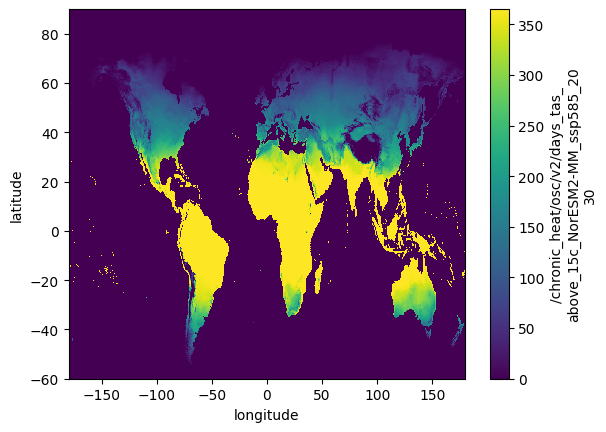

In [10]:
from hazard.sources.osc_zarr import OscZarr  # noqa: E402
import os, os.path  # noqa: E402

target = OscZarr(prefix="hazard_test")
da = target.read("chronic_heat/osc/v2/days_tas_above_15c_NorESM2-MM_ssp585_2030")
da.plot()

### List contents of 'directory'

Use s3fs to treat like directory structure, but some care needed:

- s3fs caches so care needed if objects are changed outside of s3fs
- Best to use boto3 client for handling large number of objects (see below)

In [ ]:
import s3fs  # noqa: E402

s3 = s3fs.S3FileSystem(
    anon=False,
    key=os.environ["OSC_S3_ACCESS_KEY"],
    secret=os.environ["OSC_S3_SECRET_KEY"],
)
s3.ls(os.environ["OSC_S3_BUCKET"] + "/hazard_test/hazard.zarr")

### Copy from one bucket to another bucket

Use boto3 client and paginator for dealing with large number of objects.

Some care needed if trying to move objects between buckets with different credentials: \
https://stackoverflow.com/questions/65577223/aws-s3-copy-object-from-one-bucket-to-another-with-different-credentials

In [ ]:
import boto3  # noqa: E402

bucket_name = os.environ["OSC_S3_BUCKET"]
prefix = "hazard_test/hazard.zarr/chronic_heat/osc/v2"

s3_client = boto3.client(
    "s3",
    aws_access_key_id=os.environ["OSC_S3_ACCESS_KEY"],
    aws_secret_access_key=os.environ["OSC_S3_SECRET_KEY"],
)

paginator = s3_client.get_paginator("list_objects_v2")

pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

# get the list of keys with the given prefix
keys = []
for page in pages:
    for objs in page["Contents"]:
        if isinstance(objs, list):
            keys.extend([obj["Key"] for obj in objs])
        else:
            keys.append(objs["Key"])

print(keys)

In [ ]:
# Use this script to promote from hazard_test to hazard

target_bucket_name = "..."
# might be same as bucket_name

for key in keys:
    copy_source = {"Bucket": bucket_name, "Key": key}
    target_key = key.replace("hazard_test/hazard.zarr", "hazard/hazard.zarr")
    print(f"{key} to {target_key} for bucket {bucket_name}")
    s3_client.copy_object(CopySource=copy_source, Bucket=target_bucket_name, Key=target_key)